# Modeling

## Import Libraries and the final salary data set

In [104]:
import time
import nltk
from nltk.corpus import stopwords

from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.collocations import *
import string, re

from gensim.models import Word2Vec

from sklearn.manifold import TSNE
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, r2_score

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(0)

In [3]:
salary_df = pd.read_csv("salary_final.csv")


In [4]:
salary_df.head()

,Unnamed: 0,Unnamed: 0.1,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,...,adjusted_yearly_salary,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text
0,0,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,215000.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re..."
1,1,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,215000.0,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,"2021048 Data Scientist $215,000.00 Position Re..."
2,2,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,60000.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...
3,3,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,60000.0,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,Data Science/Data Analyst Cost Readiness Analy...
4,4,8,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,...,46800.0,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10d2f5f98>]],
      dtype=object)

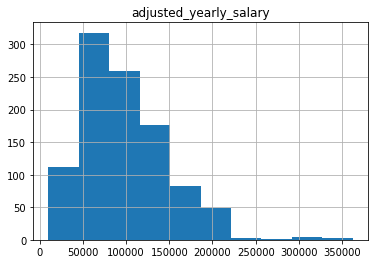

In [5]:
salary_df.hist('adjusted_yearly_salary')

In [6]:
salary_df['adjusted_yearly_salary'].max() - salary_df['adjusted_yearly_salary'].min()

352500.0

Salary bins: [< 50,000, 50,000-75,000, 75,000-100,000, 100,000-125,000, 125,000-150,000, 150,000-175,000, 175,000-200,000, 200,000-225,000, 225,000-250,000, >250,000]

In [7]:
salary_df['adjusted_yearly_salary'].quantile(list(np.linspace(0,1,11)))

0.0     10000.00
0.1     44916.00
0.2     57796.00
0.3     67500.00
0.4     77500.00
0.5     91434.00
0.6    105000.00
0.7    119421.00
0.8    140000.00
0.9    168143.44
1.0    362500.00
Name: adjusted_yearly_salary, dtype: float64

In [8]:
#Create Bins
BINS = [0,50000,75000,100000,125000,150000,175000,200000,400000]

In [9]:
salary_df['Salary_Bins'] = pd.cut(x=salary_df['adjusted_yearly_salary'], bins=BINS, labels=False)

In [10]:
salary_df['Salary_Bins']

0       7
1       7
2       1
3       1
4       0
       ..
1003    3
1004    2
1005    2
1006    2
1007    2
Name: Salary_Bins, Length: 1008, dtype: int64

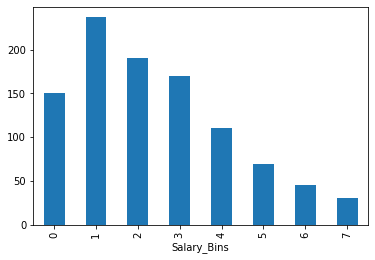

In [11]:
salary_df.groupby('Salary_Bins')['Location2'].count().plot.bar()

In [12]:
#Categorical target
target_class = salary_df['Salary_Bins'].astype('category')

In [13]:
def clean_word(job_descriptions):
    jd_data=[]
    pattern = "([a-zA-Z]+(?:'[a-z]+)?)"
    stopwords_list = stopwords.words('english')
    stopwords_list += list(string.punctuation)
    stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
    
    for jd in job_descriptions:
        jd_tokens_raw = nltk.regexp_tokenize(jd, pattern)
        jd_tokens=[word.lower() for word in jd_tokens_raw]
        jd_words_stopped = [word for word in jd_tokens if word not in stopwords_list]
        jd_data.append(jd_words_stopped)
    return pd.Series(jd_data) # Turn list of lists to series of lists to use in Word2Vec

In [14]:
data = clean_word(salary_df['combined_text'])
target = salary_df['adjusted_yearly_salary'] #continuous target
target_class = salary_df['Salary_Bins'].astype('category') #categorical target

## Model 1:  Use Word2Vec Model 

We are going to use Word2Vec model in this section. Word2vec is a group of related models that are used to produce word embeddings. These models are shallow, two-layer neural networks that are trained to reconstruct linguistic contexts of words. Word2vec takes as its input a large corpus of text and produces a vector space, typically of several hundred dimensions, with each unique word in the corpus being assigned a corresponding vector in the space. Word vectors are positioned in the vector space such that words that share common contexts in the corpus are located close to one another in the space.

We need to specify following parameter to the model:
* the `size` of the word vectors we want to learn 
* the `window` size to use when training the model
* `min_count`, which corresponds to the minimum number of times a word must be used in the corpus in order to be included in the training (for instance, `min_count=5` would only learn word embeddings for words that appear 5 or more times throughout the entire training set)
* `workers`, the number of threads to use for training, which can speed up processing (`4` is typically used, since most processors nowadays have at least 4 cores)

In [ ]:
data[0]

### Random Forest Regressor,  Linear SVC and Linear Regression in the pipeline

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
TF-IDF embedding, focus on important words.


https://scikit-learn.org/stable/modules/classes.html
#module-sklearn.feature_extraction.text
https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html

#### Word2Vec Model from scratch

In [0]:
model = Word2Vec(data,
                size=500,
                window=5,
                min_count=2,
                workers=4)

In [0]:
model.train(data,total_examples=model.corpus_count, epochs=10)

(3431362, 3673340)

In [0]:
wv = model.wv

In [0]:
wv.vector_size

500

In [0]:
wv.most_similar('data')

[('extraction', 0.5246098637580872),
 ('cleaning', 0.5221850872039795),
 ('unstructured', 0.517565906047821),
 ('etl', 0.5145159363746643),
 ('sets', 0.5127720236778259),
 ('large', 0.5070561170578003),
 ('manipulate', 0.49055036902427673),
 ('dashboards', 0.49043816328048706),
 ('raw', 0.4901886582374573),
 ('manipulating', 0.48749840259552)]

To be able to use in a pipeline, need fit and transform

In [0]:
w2v = dict(zip(model.wv.index2word, model.wv.syn0))

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.vectors instead).
  """Entry point for launching an IPython kernel.


In [0]:
len(w2v.values())

9364

Averaging word vectors for all words in a text.

In [0]:
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        # if a text is empty we should return a vector of zeros
        # with the same dimensionality as all the other vectors
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([
            np.mean([self.word2vec[w] for w in words if w in self.word2vec]
                    or [np.zeros(self.dim)], axis=0)
            for words in X
        ])

In [0]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=3, verbose=True, n_jobs=3))])

svc = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Support Vector Machine', SVC(kernel='rbf', C=0.5))])

sgd = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
               ('Stochastic Gradient Descent', SGDClassifier(alpha=0.001, n_jobs=3))])

#svr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('SVR-lin', SVR(kernel='rbf', C=0.5))])
                
#lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('Linear Regression', LinearRegression(n_jobs=3))])

In [0]:
rf =  Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestClassifier(n_estimators=100, criterion='entropy', min_samples_leaf=3, verbose=True, n_jobs=3))])


In [0]:
cross_val_score(rf, data, target_class, cv=2).mean()

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  89 tasks      | elapsed:    2.8s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    2.8s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


0.3670634920634921

In [0]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc),
          ('Stochastic Gradient Descent', sgd)]
          #('Linear Regression', lr)]

In [0]:
scores = [(name, cross_val_score(model, data, target_class, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    2.4s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.3s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done  50 out of  50 | elapsed:    0.0s finished


In [0]:
scores

[('Random Forest', 0.3680555555555556),
 ('Support Vector Machine', 0.33134920634920634),
 ('Stochastic Gradient Descent', 0.33333333333333337)]

TD-IDF Embedding

In [0]:
class TfidfEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        self.word2weight = None
        self.dim = len(word2vec.values())

    def fit(self, X, y):
        tfidf = TfidfVectorizer(analyzer=lambda x: x)
        tfidf.fit(X)
        # if a word was never seen - it must be at least as infrequent
        # as any of the known words - so the default idf is the max of 
        # known idf's
        max_idf = max(tfidf.idf_)
        self.word2weight = defaultdict(
            lambda: max_idf,
            [(w, tfidf.idf_[i]) for w, i in tfidf.vocabulary_.items()])

        return self

    def transform(self, X):
        return np.array([
                np.mean([self.word2vec[w] * self.word2weight[w]
                         for w in words if w in self.word2vec] or
                        [np.zeros(self.dim)], axis=0)
                for words in X
            ])

In [0]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', TfidfEmbeddingVectorizer(w2v)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svc = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              ('Support Vector Machine', SVC(kernel='rbf', C=0.5))])

#svr = Pipeline([('Word2Vec Vectorizer', TfidfEmbeddingVectorizer(w2v)),
             # ('SVR-lin', SVR(kernel='rbf'))])
                
#lr = Pipeline([('Word2Vec Vectorizer', MeanEmbeddingVectorizer(w2v)),
              #('Linear Regression', LinearRegression(n_jobs=3))])

In [0]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svc)]
          #('Linear Regression', lr)]

In [0]:
scores = [(name, cross_val_score(model, data, target_class, cv=2).mean()) for name, model, in models]

/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NameError: name 'defaultdict' is not defined

  FitFailedWarning)
/Applications/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
NameError: name 'defaultdict' is not defined

  FitFailedWarning)


In [0]:
scores

[('Random Forest', nan), ('Support Vector Machine', 0.3208715418258987)]

#### Try other vectorizers with GridSearch


In [10]:
!pip install pprint

In [15]:
from pprint import pprint
from time import time
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [35]:
text = salary_df['combined_text']

In [38]:
target_class

0       7
1       7
2       1
3       1
4       0
       ..
1003    3
1004    2
1005    2
1006    2
1007    2
Name: Salary_Bins, Length: 1008, dtype: category
Categories (8, int64): [0, 1, 2, 3, 4, 5, 6, 7]

In [39]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 100, 200, 300),
    'vect__ngram_range': (1, 2),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,30),
    'clf__alpha': (0.00001, 0.0001)
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

if __name__ == "__main__":
    # multiprocessing requires the fork to happen in a __main__ protected
    # block

    # find the best parameters for both the feature extraction and the
    # classifier
    grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

    print("Performing grid search...")
    print("pipeline:", [name for name, _ in pipeline.steps])
    print("parameters:")
    pprint(parameters)
    t0 = time()
    grid_search.fit(text, target_class)
    print("done in %0.3fs" % (time() - t0))
    print()

    print("Best score: %0.3f" % grid_search.best_score_)
    print("Best parameters set:")
    best_parameters = grid_search.best_estimator_.get_params()
    for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 0.0001),
 'clf__max_iter': (20, 30),
 'tfidf__norm': ('l1', 'l2'),
 'tfidf__use_idf': (True, False),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__max_features': (None, 100, 200, 300),
 'vect__ngram_range': (1, 2)}
Fitting 5 folds for each of 384 candidates, totalling 1920 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done 1913 out of 1920 | elapsed:    3.7s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1920 out of 1920 | elapsed:    3.8s finished


TypeError: cannot unpack non-iterable int object

Confusion matrix to interpret the score better. If predicting lower bins better, can combine some of them.  

In [32]:
y = np.array(target_class)

In [33]:
type(y[0])

numpy.int64

In [34]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', RandomForestClassifier())
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    #'vect__max_features': (None, 100, 200, 300),
    'vect__ngram_range': (1, 2),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2'),
    #'clf__n_estimators':(50,100,200),
    #'clf__max_features':('auto','log2'),
    #'clf__min_samples_split':(2,5,10)
    #'clf__max_iter': (20,),
    #'clf__alpha': (0.00001, 0.000001),
    #'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)
grid_search.fit(text, y)


print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:    0.7s finished


TypeError: cannot unpack non-iterable int object

In [29]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1000, n_features=4,
                           n_informative=2, n_redundant=0,
                         random_state=0, shuffle=False)
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X, y)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=2, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [30]:
type(y[0])

numpy.int64

### Use Pretrained GloVe Model

#### Getting the Total Vocabulary

In [0]:
total_vocabulary = set(word for jd in data for word in jd)

In [0]:
len(total_vocabulary)
print('There are {} unique tokens in the dataset.'.format(len(total_vocabulary)))

There are 13283 unique tokens in the dataset.


In [0]:
#Get the appropriate vectors out of the GloVe file
glove = {}
with open('glove_6B_50d.txt', 'rb') as f:
    for line in f:
        parts = line.split()
        word = parts[0].decode('utf-8')
        if word in total_vocabulary:
            vector = np.array(parts[1:], dtype=np.float32)
            glove[word] = vector

In [0]:
glove['data']

array([ 5.3101e-01, -5.5869e-01,  1.7674e+00,  4.4824e-01,  2.2341e-01,
       -3.4559e-01, -7.7679e-01, -9.6117e-01,  1.1669e+00,  7.4279e-02,
        8.1470e-01, -5.9428e-02,  6.4599e-02,  1.5176e-03,  9.9179e-02,
        3.6602e-01, -9.8724e-01, -8.3913e-01,  1.5917e-01, -7.7603e-01,
        7.3474e-01, -6.4861e-01,  4.6174e-01,  8.8162e-03,  5.1738e-01,
       -6.5976e-01, -7.4010e-01, -1.3928e-01,  8.1094e-02,  2.0657e-01,
        3.5652e+00, -8.2264e-01,  5.7360e-01, -1.7268e+00,  6.2356e-03,
        6.7672e-02, -2.3411e-01,  3.5163e-02,  2.6507e-01, -2.9966e-01,
        7.4323e-01, -4.5027e-01,  1.9406e-01,  4.8611e-01, -4.3075e-01,
       -2.5210e-01,  1.2774e+00,  1.5815e+00,  6.5838e-01, -2.0978e-01],
      dtype=float32)

In [0]:
len(next(iter(glove)))

In [0]:
class W2vVectorizer(object):
    
    def __init__(self, w2v):
        # Takes in a dictionary of words and vectors as input
        self.w2v = w2v
        if len(w2v) == 0:
            self.dimensions = 0
        else:
            self.dimensions = len(w2v[next(iter(glove))])
    
    # Note: Even though it doesn't do anything, it's required that this object implement a fit method or else
    # it can't be used in a scikit-learn pipeline  
    def fit(self, X, y):
        return self
            
    def transform(self, X):
        return np.array([
            np.mean([self.w2v[w] for w in words if w in self.w2v]
                   or [np.zeros(self.dimensions)], axis=0) for words in X])

To be able to use in a pipeline, need fit and transform

### Use Random Forest Regressor and Linear Regression in the pipeline

http://nadbordrozd.github.io/blog/2016/05/20/text-classification-with-word2vec/
TF-IDF embedding, focus on important words.

In [0]:
#Use pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVC
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

rf =  Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Random Forest', RandomForestRegressor(n_estimators=100, verbose=True, n_jobs=3))])
svr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
                ('Support Vector Machine', SVR(kernel='linear'))])
lr = Pipeline([('Word2Vec Vectorizer', W2vVectorizer(glove)),
              ('Linear Regression', LinearRegression())])

In [0]:
models = [('Random Forest', rf),
          ('Support Vector Machine', svr),
          ('Linear Regression', lr)]

In [0]:
scores = [(name, cross_val_score(model, data, target, cv=2).mean()) for name, model, in models]

[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  89 tasks      | elapsed:    1.5s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    1.6s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.5s finished
[Parallel(n_jobs=3)]: Using backend ThreadingBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done  44 tasks      | elapsed:    0.0s
[Parallel(n_jobs=3)]: Done 100 out of 100 | elapsed:    0.0s finished


In [0]:
scores

[('Random Forest', 0.23296344891439746),
 ('Support Vector Machine', -0.12380575212964273),
 ('Linear Regression', 0.21515161505580238)]

The score is pretty low. There is plenty of room to improve the model performance: standardize the scale of salary, add more parameters to the regression model.

## Model 2: Deep Learning Models with Word Embeddings

In [92]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, Activation, Bidirectional, GlobalMaxPool1D
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.preprocessing import text, sequence
from keras.layers import Flatten

from keras.utils import to_categorical

import matplotlib.pyplot as plt

In [17]:
#Encoding to categorical classes
y = to_categorical(target_class.values, num_classes=8, dtype="float32")


In [18]:
y.shape

(1008, 8)

#### Word Embedding

We will map each job description into a real vector domain, a popular technique when working with text called word embedding. This is a technique where words are encoded as real-valued vectors in a high dimensional space, where the similarity between words in terms of meaning translates to closeness in the vector space.

Keras provides a convenient way to convert positive integer representations of words into a word embedding by an Embedding layer.

We will map each word onto a 32 length real valued vector (embedding size). We will also limit the total number of words that we are interested in modeling to the 500 most frequent words, and zero out the rest. Finally, the sequence length (number of words) in each review varies, so we will constrain each job description to be 500 words, truncating long reviews and pad the shorter reviews with zero values. 

In [137]:
tokenizer = text.Tokenizer() 
tokenizer.num_words = 1000  #limit the number of words to keep most common 1000 words
tokenizer.fit_on_texts(list(salary_df['combined_text']))
list_tokenized_jd = tokenizer.texts_to_sequences(salary_df['combined_text'])

X_t = sequence.pad_sequences(list_tokenized_jd, maxlen=500, padding = 'post') 

In [138]:
X_t.shape

(1008, 500)

In [139]:
len(list_tokenized_jd)

1008

In [140]:
y.shape

(1008, 8)

#### Train-Test Split

In [141]:
X_train, X_test, y_train, y_test = train_test_split(X_t, y, test_size=0.1, random_state=4)

In [142]:
X_test.shape

(101, 500)

In [143]:
y_test.shape

(101, 8)

In [0]:
#Transform features by scaling each feature to a given range
from sklearn.preprocessing import MinMaxScaler

scalarX_train, scalarX_test, scalarY_train, scalarY_test = MinMaxScaler(), MinMaxScaler(), MinMaxScaler(), MinMaxScaler()
scalarX_train.fit(X_train)
scalarY_train.fit(y_train.reshape(866,1))
scalarX_test.fit(X_test)
scalarY_test.fit(y_test.reshape(97,1))
X_train_new = scalarX_train.transform(X_train)
y_train_new = scalarY_train.transform(y_train.reshape(866,1))
X_test_new = scalarX_test.transform(X_test)
y_test_new = scalarY_test.transform(y_test.reshape(97,1))

In [0]:
X_train_new.shape

(866, 100)

In [0]:
y_train_new.shape

(866, 1)

### Create a base model

In [85]:
model = Sequential()

embedding_size = 32  #each word onto a 32 length real valued vector
model.add(Embedding(input_dim = 1000, output_dim = embedding_size, input_length = 500)) #try 100, 200, single LSTM and single dense 100
model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(64))
#model.add(GlobalMaxPool1D())
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Flatten())   #add Flatten layer 
model.add(Dense(8, activation='softmax'))

In [86]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 500, 32)           32000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 128)          82432     
_________________________________________________________________
dense_12 (Dense)             (None, 500, 100)          12900     
_________________________________________________________________
dropout_8 (Dropout)          (None, 500, 100)          0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 50000)             0         
_________________________________________________________________
dense_13 (Dense)             (None, 8)                 400008    
Total params: 527,340
Trainable params: 527,340
Non-trainable params: 0
________________________________________________

In [87]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [88]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=[X_test, y_test])

Train on 907 samples, validate on 101 samples
Epoch 1/30
704/907 [======================>.......] - ETA: 2s - loss: 1.9265 - accuracy: 0.2145

KeyboardInterrupt: 

Hyperparameter testing (layer size, learning rate) 
Grid Search: https://github.com/autonomio/talos
https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
Google Collab

Train: 1.000, Test: 0.505


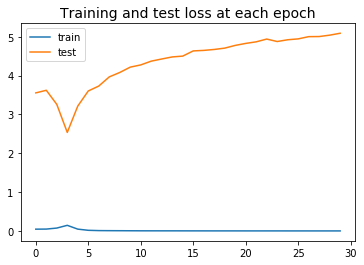

In [82]:


# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train: %.3f, Test: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title('Training and test loss at each epoch', fontsize=14)
plt.legend()
plt.show()


The Neural Network model with LSTM layer performed better than previous SGD or RF Classification models. However, it may overfit the data. We will perform some hyperparameter tuning in the following section.

### Tuning the Network Model

- Use Word2Vec embedding
- Optimizers
- Learning Rate
- Batch Size
- Regularization: prevent overfitting
- Dropout
- Early Stopping

In [96]:
#Add Convolutional Layer and MaxPooling Layer
model = Sequential()

embedding_size = 32  #each word onto a 32 length real valued vector
model.add(Embedding(input_dim = 1000, output_dim = embedding_size, input_length = 500)) #try 100, 200, single LSTM and single dense 100
model.add(Conv1D(filters=32, kernel_size = 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))
#model.add(LSTM(64))
#model.add(GlobalMaxPool1D())
#model.add(Dropout(0.5))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
#model.add(Dense(32, activation='relu'))
model.add(Flatten())   #add Flatten layer 
model.add(Dense(8, activation='softmax'))

In [97]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [98]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 500, 32)           32000     
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 500, 32)           3104      
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 250, 32)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 250, 128)          82432     
_________________________________________________________________
dense_16 (Dense)             (None, 250, 100)          12900     
_________________________________________________________________
dropout_10 (Dropout)         (None, 250, 100)          0         
_________________________________________________________________
flatten_8 (Flatten)          (None, 25000)           

In [99]:
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=[X_test, y_test])

Train on 907 samples, validate on 101 samples
Epoch 1/30
907/907 [==============================] - 7s 8ms/step - loss: 1.9367 - accuracy: 0.2293 - val_loss: 2.0803 - val_accuracy: 0.1386
Epoch 2/30
907/907 [==============================] - 6s 7ms/step - loss: 1.8426 - accuracy: 0.2580 - val_loss: 1.8784 - val_accuracy: 0.1881
Epoch 3/30
907/907 [==============================] - 6s 7ms/step - loss: 1.6056 - accuracy: 0.3638 - val_loss: 1.8478 - val_accuracy: 0.2871
Epoch 4/30
907/907 [==============================] - 6s 7ms/step - loss: 1.4124 - accuracy: 0.4223 - val_loss: 1.6676 - val_accuracy: 0.2871
Epoch 5/30
907/907 [==============================] - 6s 7ms/step - loss: 1.1758 - accuracy: 0.5193 - val_loss: 1.7277 - val_accuracy: 0.3960
Epoch 6/30
907/907 [==============================] - 6s 7ms/step - loss: 0.9638 - accuracy: 0.6196 - val_loss: 1.6569 - val_accuracy: 0.4257
Epoch 7/30
907/907 [==============================] - 6s 7ms/step - loss: 0.7501 - accuracy: 0.7133 - 

Train Accuracy: 1.000, Test Accuracy: 0.515


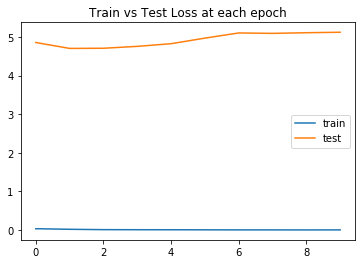

In [115]:
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Train vs Test Loss at each epoch")
plt.legend()
plt.show()

Try fewer input dimension and input words, add Early Stop layer. 

In [148]:
#Add Early Stopping layer, L1 and L2 regularization
from keras.callbacks import EarlyStopping
from keras import regularizers


model = Sequential()
embedding_size = 64  #each word onto a 32 length real valued vector
model.add(Embedding(input_dim = 1000, output_dim = embedding_size, input_length = 500)) #try 100, 200, single LSTM and single dense 100
model.add(Conv1D(filters=32, kernel_size = 3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.5))
model.add(Flatten())   #add Flatten layer 
model.add(Dense(8, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])


Train on 907 samples, validate on 101 samples
Epoch 1/30
907/907 [==============================] - 8s 9ms/step - loss: 1.9354 - accuracy: 0.2194 - val_loss: 1.9799 - val_accuracy: 0.1386
Epoch 2/30
907/907 [==============================] - 7s 7ms/step - loss: 1.8568 - accuracy: 0.2404 - val_loss: 1.9903 - val_accuracy: 0.1782
Epoch 3/30
907/907 [==============================] - 7s 7ms/step - loss: 1.6685 - accuracy: 0.3197 - val_loss: 2.2110 - val_accuracy: 0.3168
Epoch 4/30
907/907 [==============================] - 7s 7ms/step - loss: 1.4865 - accuracy: 0.3936 - val_loss: 1.7135 - val_accuracy: 0.2871
Epoch 5/30
907/907 [==============================] - 7s 7ms/step - loss: 1.2415 - accuracy: 0.5281 - val_loss: 1.6493 - val_accuracy: 0.2970
Epoch 6/30
907/907 [==============================] - 7s 8ms/step - loss: 1.0580 - accuracy: 0.5910 - val_loss: 1.7719 - val_accuracy: 0.3168
Epoch 7/30
907/907 [==============================] - 7s 7ms/step - loss: 0.8364 - accuracy: 0.6858 - 

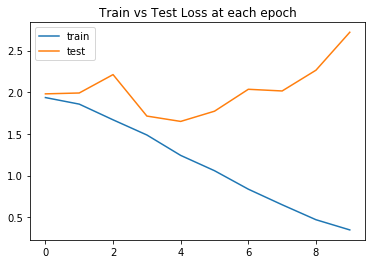

In [149]:
es = EarlyStopping(monitor='val_loss', patience = 5, mode='min', verbose=1)

history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=[X_test, y_test], callbacks=[es])
# evaluate the model
_, train_acc = model.evaluate(X_train, y_train, verbose=0)
_, test_acc = model.evaluate(X_test, y_test, verbose=0)
print('Train Accuracy: %.3f, Test Accuracy: %.3f' % (train_acc, test_acc))
# plot training history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.title("Train vs Test Loss at each epoch")
plt.legend()
plt.show()

### Mixed Input Model with City, Rate Type and Cost of Living Indexes

Use Functional API:  https://machinelearningmastery.com/keras-functional-api-deep-learning/

Multi-input full example: https://www.pyimagesearch.com/2019/02/04/keras-multiple-inputs-and-mixed-data/

#### Explore continuous variables and categorical variables

In [150]:
salary_df.head()

,Unnamed: 0,Unnamed: 0.1,Title,Company,Link,Review,Salary,Description,Location2,Rate_by,...,Rank,City,Cost of Living Index,Rent Index,Cost of Living Plus Rent Index,Groceries Index,Restaurant Price Index,Local Purchasing Power Index,combined_text,Salary_Bins
0,0,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,"2021048 Data Scientist $215,000.00 Position Re...",7
1,1,2,"2021048 Data Scientist $215,000.00",B4CORP,https://www.indeed.com/pagead/clk?mo=r&ad=-6NY...,None,"Up to $215,000 a year",Position Requires a Top Secret (TS/SCI) Cleara...,"Arlington, VA",Yearly,...,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,"2021048 Data Scientist $215,000.00 Position Re...",7
2,2,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science/Data Analyst Cost Readiness Analy...,1
3,3,6,Data Science/Data Analyst,CRAiC LLC,https://www.indeed.com/company/CRAiC-LLC/jobs/...,None,"$60,000 a year",Cost Readiness Analytics (CRAiC LLC) is lookin...,"Arlington, VA",Yearly,...,61.0,"Arlington, VA",67.200000,33.880000,51.260000,59.130000,76.440000,112.570000,Data Science/Data Analyst Cost Readiness Analy...,1
4,4,8,Data Science Intern,MilliporeSigma,https://www.indeed.com/company/Serono/jobs/Dat...,3.9,$20 - $25 an hour,Job Title: Data Science Intern\rA career with ...,"Arlington, VA",Hourly,...,36.0,"Arlington, VA",80.159143,58.838571,69.961143,76.886286,78.608571,115.594571,Data Science Intern Job Title: Data Science In...,0


In [159]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

cont_features = ['Cost of Living Index','Rent Index','Cost of Living Plus Rent Index','Local Purchasing Power Index']
X_cont_df = salary_df.loc[:, cont_features]

In [160]:
X_cont_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 4 columns):
Cost of Living Index              938 non-null float64
Rent Index                        938 non-null float64
Cost of Living Plus Rent Index    938 non-null float64
Local Purchasing Power Index      938 non-null float64
dtypes: float64(4)
memory usage: 31.6 KB


In [162]:
X_cont

array([[ 80.15914286,  58.83857143,  69.96114286, 115.59457143],
       [ 67.2       ,  33.88      ,  51.26      , 112.57      ],
       [ 80.15914286,  58.83857143,  69.96114286, 115.59457143],
       ...,
       [ 87.74      ,  78.18      ,  83.17      , 130.25      ],
       [ 87.74      ,  78.18      ,  83.17      , 130.25      ],
       [ 87.74      ,  78.18      ,  83.17      , 130.25      ]])

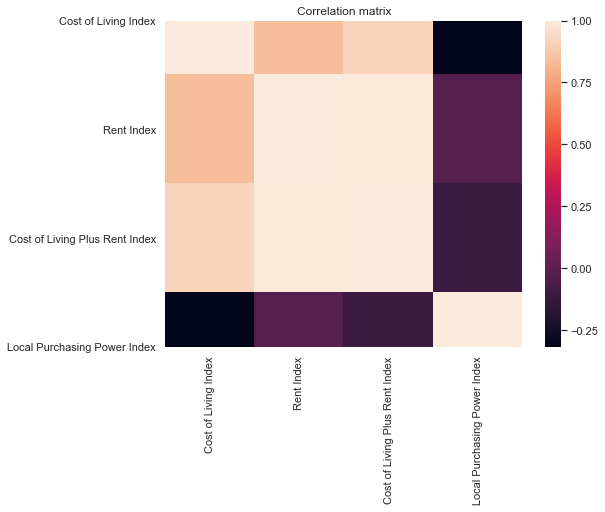

In [165]:
#Look at the correlation among continous variables
import numpy as np
np.random.seed(0)
import seaborn as sns
sns.set()
plt.figure(figsize=(8,6))
ax = sns.heatmap(X_cont_df.corr())
plt.title("Correlation Matrix")
plt.show()

Looks like Cost of Living Index largely correlates with Rent Index and negatively correlates with Local Purchasing Power Index. We will keep Cost of Living Plus Rent Index and Local Purchasing Power Index in this model. 

In [169]:
#Keep Cost of Living Plus Rent Index, Local Purchasing Power and Fill missing values with the mean

cont_imp = SimpleImputer(strategy='mean')
cont_imp.fit(X_cont_df[['Cost of Living Plus Rent Index','Local Purchasing Power Index']])
X_cont = cont_imp.transform(X_cont_df[['Cost of Living Plus Rent Index','Local Purchasing Power Index']])

#Standardized inputs

sc=StandardScaler()
sc.fit(X_cont)
X_cont_scaled = sc.transform(X_cont)

#Continous Features Dataframe
cont_scaled_df = pd.DataFrame(X_cont_scaled, columns = ['Cost of Living Plus Rent Index','Local Purchasing Power Index'])

In [170]:
cont_scaled_df

,Cost of Living Plus Rent Index,Local Purchasing Power Index
0,-0.367050,-0.605911
1,-1.551282,-0.807275
2,-0.367050,-0.605911
3,-1.551282,-0.807275
4,-0.367050,-0.605911
...,...,...
1003,0.469387,0.369787
1004,0.469387,0.369787
1005,0.469387,0.369787
1006,0.469387,0.369787


In [172]:
#Categorical Features

cat_features=['City','Rate_by']
X_cat = salary_df.loc[:, cat_features]

# Replace NaNs with 'missing'
cat_imp = SimpleImputer(strategy='constant', fill_value='missing')
cat_imp.fit(X_cat)
X_cat = cat_imp.transform(X_cat)

#Encode Categorical Features
ohe = OneHotEncoder(handle_unknown='ignore')
ohe.fit(X_cat)
X_cat_ohe = ohe.transform(X_cat)

#Create categorical features dataframe
cat_df = pd.DataFrame(X_cat_ohe.todense(), columns=ohe.get_feature_names(input_features=cat_features))

In [174]:
cat_df

,"City_Arlington, VA","City_Atlanta, GA","City_Austin, TX","City_Boston, MA","City_Cambridge, MA","City_Charlotte, NC","City_Chicago, IL","City_Dallas, TX","City_Denver, CO","City_Houston, TX",...,"City_San Antonio, TX","City_San Francisco, CA","City_San Jose, CA","City_Seattle, WA","City_Washington, DC",City_missing,Rate_by_Daily,Rate_by_Hourly,Rate_by_Monthly,Rate_by_Yearly
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1004,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1005,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1006,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


Combine contious and categorical variables into one dataframe

In [200]:
#Other_inputs = pd.concat([cont_scaled_df, cat_df], axis=1)
Other_inputs = cont_scaled_df

In [201]:
Other_inputs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1008 entries, 0 to 1007
Data columns (total 2 columns):
Cost of Living Plus Rent Index    1008 non-null float64
Local Purchasing Power Index      1008 non-null float64
dtypes: float64(2)
memory usage: 15.9 KB


In [202]:
#Train Test split on other inputs

X2_train, X2_test, y_train, y_test = train_test_split(Other_inputs, y, test_size=0.1, random_state=4)

In [203]:
X2_train.shape

(907, 2)

In [204]:
X_train.shape

(907, 500)

#### Put them together

In [187]:
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
from keras.optimizers import Adam

In [205]:
# define two sets of inputs
inputA = Input(shape=(2,)) #non-words input
inputB = Input(shape=(500,))  #word vectors 

# the first branch operates on the first input
hiddenA1 = Dense(16, activation="relu")(inputA)
hiddenA2 = Dense(16, activation="relu")(hiddenA1)
outputA = Dense(8, activation="softmax")(hiddenA2)
modelA = Model(inputs=inputA, outputs=outputA)

# the second branch opreates on the second input
embedB1 =  Embedding(input_dim = 1000, output_dim = 32, input_length = 500)(inputB) #each word onto a 32 length real valued vector
convB1 = Conv1D(filters=32, kernel_size = 3, padding='same', activation='relu')(embedB1)
poolB1 = MaxPooling1D(pool_size=2)(convB1)
LSTMB1 = LSTM(128, return_sequences=True)(poolB1)
hiddenB1 = Dense(100, activation='relu')(LSTMB1)
dropB1 = Dropout(0.5)(hiddenB1)
flat = Flatten()(dropB1)
outputB = Dense(8, activation='softmax')(flat)
modelB = Model(inputs=inputB, outputs=outputB)

# combine the output of the two branches
combined = concatenate([modelA.output, modelB.output])
# apply a FC layer and then a regression prediction on the
# combined outputs
z = Dense(16, activation="relu")(combined)
z = Dense(8, activation="softmax")(z)
# our model will accept the inputs of the two branches and
# then output a single value
model = Model(inputs=[modelA.input, modelB.input], outputs=z)

In [206]:
opt = Adam(lr=1e-3, decay=1e-3/200)
model.compile(loss = 'categorical_crossentropy', metrics=['accuracy'], optimizer=opt)

In [207]:
model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 500)          0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)        (None, 500, 32)      32000       input_14[0][0]                   
__________________________________________________________________________________________________
conv1d_16 (Conv1D)              (None, 500, 32)      3104        embedding_26[0][0]               
__________________________________________________________________________________________________
max_pooling1d_16 (MaxPooling1D) (None, 250, 32)      0           conv1d_16[0][0]                  
___________________________________________________________________________________________

In [208]:
model.fit([X2_train,X_train], y_train, validation_data = ([X2_test, X_test], y_test), epochs=30,batch_size=32)

Train on 907 samples, validate on 101 samples
Epoch 1/30
907/907 [==============================] - 8s 9ms/step - loss: 2.0798 - accuracy: 0.1345 - val_loss: 2.0736 - val_accuracy: 0.1386
Epoch 2/30
907/907 [==============================] - 6s 7ms/step - loss: 2.0364 - accuracy: 0.2459 - val_loss: 2.0525 - val_accuracy: 0.1386
Epoch 3/30
907/907 [==============================] - 6s 7ms/step - loss: 2.0016 - accuracy: 0.2459 - val_loss: 2.0362 - val_accuracy: 0.1386
Epoch 4/30
907/907 [==============================] - 6s 7ms/step - loss: 1.9691 - accuracy: 0.2459 - val_loss: 2.0283 - val_accuracy: 0.1386
Epoch 5/30
907/907 [==============================] - 7s 7ms/step - loss: 1.9492 - accuracy: 0.2459 - val_loss: 2.0227 - val_accuracy: 0.1386
Epoch 6/30
907/907 [==============================] - 7s 8ms/step - loss: 1.9304 - accuracy: 0.2459 - val_loss: 2.0190 - val_accuracy: 0.1386
Epoch 7/30
907/907 [==============================] - 6s 7ms/step - loss: 1.9168 - accuracy: 0.2459 - 